## Goal

Create the same arhitecture in different ways going more low level each time. All accuracies and losses should end up being similar (~0.1% degree of error because of conversions between double and float)

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np

seed = 0
%matplotlib inline

In [2]:
results = {}

## Dataset

In [3]:
import torch
import torchvision

In [4]:
torch.manual_seed(seed)

In [5]:
# hyperparams
bs = 32
max_iters = 20_000
lr = 1e-3
div = 0.9
n_hidden = 200
input_dim = 28 * 28
n_classes = 10

In [6]:
train_set = torchvision.datasets.MNIST(root="./", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(root="./", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [7]:
X_trainval = train_set.data.float() / 255.
y_trainval = train_set.targets
X_test = test_set.data.float() / 255.
y_test = test_set.targets

In [8]:
X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [9]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1-div, stratify=y_trainval, random_state=42)

# Convert to PyTorch tensors and normalize
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

<ipython-input-9-4e9595382d42>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-9-4e9595382d42>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float()
<ipython-input-9-4e9595382d42>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
<ipython-input-9-4e9595382d42>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rathe

In [10]:
X_train.shape, y_train.shape

(torch.Size([54000, 28, 28]), torch.Size([54000]))

In [11]:
np_X_train = X_train.numpy()
np_y_train = y_train.numpy()
np_X_val = X_val.numpy()
np_y_val = y_val.numpy()
np_X_test = X_test.numpy()
np_y_test = y_test.numpy()

## Classic Torch NN with modules (#CheemDog)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
torch.manual_seed(seed)
np.random.seed(seed)

In [14]:
def get_batch(X, y):
    idx = torch.tensor(np.random.choice(X.shape[0], size=bs, replace=False), dtype=torch.long)
    Xb = X[idx].reshape(-1, input_dim)
    yb = y[idx]
    return Xb, yb

@torch.no_grad()
def evaluate_loss(X, y):
    outs = model(X.view(-1, input_dim))
    loss = criterion(outs, y)
    acc = (torch.argmax(outs, dim=1) == y).float().mean() * 100
    return loss.item(), acc.item()

In [15]:
class NN(nn.Module):

    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [16]:
model = NN()

# Normal distribution with Kaim init
W1 = np.random.randn(n_hidden, input_dim) * np.sqrt(2. / input_dim)
b1 = np.zeros(n_hidden)
W2 = np.random.randn(n_classes, n_hidden) * np.sqrt(1. / n_hidden)
b2 = np.zeros(n_classes)

with torch.no_grad():
    model.fc1.weight.copy_(torch.tensor(W1))
    model.fc1.bias.copy_(torch.tensor(b1))
    model.fc2.weight.copy_(torch.tensor(W2))
    model.fc2.bias.copy_(torch.tensor(b2))

In [17]:
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [18]:
for i in range(max_iters):
    X, y = get_batch(X_train, y_train)
    y_preds = model(X)
    loss = criterion(y_preds, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [19]:
torch_model_perf = (evaluate_loss(X_train, y_train), evaluate_loss(X_val, y_val), evaluate_loss(X_test, y_test))
results["torch_model"] = torch_model_perf

In [20]:
torch_model_perf

((0.3745570778846741, 89.8351821899414),
 (0.379736989736557, 89.71666717529297),
 (0.3565691113471985, 90.34000396728516))

## Using Torch Tensors with .backward()

In [21]:
import torch
import torch.nn.functional as F

In [22]:
torch.manual_seed(seed)
np.random.seed(seed)

In [23]:
def softmax(X):
    X_maxes = X.max(dim=1, keepdim=True).values
    counts = (X - X_maxes).exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    return probs

def cross_entropy(X, y):
    logprobs = softmax(X).log()
    loss = -logprobs[range(y.shape[0]), y].mean()
    return loss

def relu(X):
    return torch.maximum(torch.tensor(0), X)

@torch.no_grad()
def evaluate_loss(X, y):
    outs = X.view(-1, input_dim) @ W1.t() + b1
    outs = relu(outs)
    outs = outs @ W2.t() + b2
    loss = F.cross_entropy(outs, y)
    acc = (torch.argmax(outs, dim=1) == y).float().mean() * 100
    return loss.item(), acc.item()

In [24]:
# Normal distribution with Kaim init
W1 = np.random.randn(n_hidden, input_dim) * np.sqrt(2. / input_dim)
b1 = np.zeros(n_hidden)
W2 = np.random.randn(n_classes, n_hidden) * np.sqrt(1. / n_hidden)
b2 = np.zeros(n_classes)

W1 = torch.tensor(W1).float()
b1 = torch.tensor(b1).float()
W2 = torch.tensor(W2).float()
b2 = torch.tensor(b2).float()

params = [W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

In [25]:
for i in range(max_iters):
    X, y = get_batch(X_train, y_train)
    o1 = X @ W1.t() + b1
    a1 = relu(o1)
    o2 = a1 @ W2.t() + b2

    loss = cross_entropy(o2, y)
    for p in params:
        p.grad = None

    loss.backward()
    for p in params:
        p.data -= lr * p.grad

In [26]:
torch_auto_perf = (evaluate_loss(X_train, y_train), evaluate_loss(X_val, y_val), evaluate_loss(X_test, y_test))
results["torch_auto"] = torch_auto_perf

In [27]:
torch_auto_perf

((0.3745569884777069, 89.8351821899414),
 (0.3797368109226227, 89.71666717529297),
 (0.35656896233558655, 90.3499984741211))

## Using Torch Tensors with manual backprop and loss

In [28]:
import torch
import torch.nn.functional as F

In [29]:
torch.manual_seed(seed)
np.random.seed(seed)

In [30]:
# Normal distribution with Kaim init
W1 = np.random.randn(n_hidden, input_dim) * np.sqrt(2. / input_dim)
b1 = np.zeros(n_hidden)
W2 = np.random.randn(n_classes, n_hidden) * np.sqrt(1. / n_hidden)
b2 = np.zeros(n_classes)

W1 = torch.tensor(W1).float()
b1 = torch.tensor(b1).float()
W2 = torch.tensor(W2).float()
b2 = torch.tensor(b2).float()

dW1 = None
db1 = None
dW2 = None
db2 = None

params = [W1, b1, W2, b2]
dparams = [dW1, db1, dW2, db2]

In [31]:
for i in range(max_iters):
    # mini batch
    X, y = get_batch(X_train, y_train)

    # linear and act layers
    o1 = X @ W1.t() + b1
    a1 = relu(o1)
    o2 = a1 @ W2.t() + b2

    # loss
    loss = cross_entropy(o2, y)

    # dloss
    do2 = softmax(o2)
    do2[range(bs), y] -= 1
    do2 /= bs

    # dfc2
    da1 = do2 @ W2
    dW2 = do2.t() @ a1
    db2 = do2.sum(dim=0)

    # dact1
    do1 = da1 * (o1 > 0).float()

    # dfc1
    dW1 = do1.t() @ X
    db1 = do1.sum(dim=0)

    dparams = [dW1, db1, dW2, db2]
    for p, dp in zip(params, dparams):
        p -= dp * lr
        dp = None

loss.item()

0.2845746576786041

In [32]:
torch_manual_perf = (evaluate_loss(X_train, y_train), evaluate_loss(X_val, y_val), evaluate_loss(X_test, y_test))
results["torch_manual"] = torch_manual_perf

## Using Numpy (#SwoleDog)

In [33]:
import numpy as np

In [34]:
torch.manual_seed(seed)
np.random.seed(seed)

In [35]:
def np_softmax(X):
    X_maxes = X.max(axis=1, keepdims=True)
    counts = np.exp(X - X_maxes)
    probs = counts / np.sum(counts, axis=1, keepdims=True)
    return probs

def np_cross_entropy(X, y):
    logprobs = np.log(np_softmax(X))
    loss = -np.mean(logprobs[range(y.shape[0]), y])
    return loss

def np_relu(X):
    return np.maximum(X, 0)

def np_get_batch(X, y):
    idx = np.random.choice(X.shape[0], size=bs, replace=False)
    Xb = X[idx].reshape((-1, input_dim))
    yb = y[idx]
    return Xb, yb

def np_evaluate_loss(X, y):
    outs = np_relu(np.matmul(X.reshape(-1, input_dim), W1.T) + b1)
    outs = np.matmul(outs, W2.T) + b2
    test_loss = np_cross_entropy(outs, y)
    acc = np.mean((np.equal(np.argmax(outs, axis=1), y)).astype(float)) * 100
    return loss, acc

In [36]:
# Normal distribution with Kaim init
W1 = np.random.randn(n_hidden, input_dim) * np.sqrt(2. / input_dim)
b1 = np.zeros(n_hidden)
W2 = np.random.randn(n_classes, n_hidden) * np.sqrt(1. / n_hidden)
b2 = np.zeros(n_classes)

dW1 = None
db1 = None
dW2 = None
db2 = None

params = [W1, b1, W2, b2]
dparams = [dW1, db1, dW2, db2]

In [37]:
for i in range(max_iters):
    X, y = np_get_batch(np_X_train, np_y_train)

    # linear and act layers
    o1 = np.matmul(X, W1.T) + b1
    a1 = np_relu(o1)
    o2 = np.matmul(a1, W2.T) + b2

    # loss
    loss = np_cross_entropy(o2, y)

    # dloss
    do2 = np_softmax(o2)
    do2[range(bs), y] -= 1
    do2 /= bs

    # dfc2
    da1 = np.matmul(do2, W2)
    dW2 = np.matmul(do2.T, a1)
    db2 = np.sum(do2, axis=0)

    # dact1
    do1 = da1 * (o1 > 0).astype(float)

    # dfc1
    dW1 = np.matmul(do1.T, X)
    db1 = np.sum(do1, axis=0)

    dparams = [dW1, db1, dW2, db2]
    for p, dp in zip(params, dparams):
        p -= dp * lr
        dp = None

In [38]:
np_manual_perf = (np_evaluate_loss(np_X_train, np_y_train), np_evaluate_loss(np_X_val, np_y_val), np_evaluate_loss(np_X_test, np_y_test))
results["np_manual"] = np_manual_perf

## Results

In [39]:
results["torch_model"]

((0.3745570778846741, 89.8351821899414),
 (0.379736989736557, 89.71666717529297),
 (0.3565691113471985, 90.34000396728516))

In [40]:
results["torch_auto"]

((0.3745569884777069, 89.8351821899414),
 (0.3797368109226227, 89.71666717529297),
 (0.35656896233558655, 90.3499984741211))

In [41]:
results["torch_manual"]

((0.3745570778846741, 89.8351821899414),
 (0.379736989736557, 89.71666717529297),
 (0.3565691113471985, 90.34000396728516))

In [42]:
results["np_manual"]

((0.2845722178214382, 89.83518518518518),
 (0.2845722178214382, 89.71666666666667),
 (0.2845722178214382, 90.36))

In [66]:
def np_predict(X):
    if X.shape[-1] != input_dim:
        X = X.reshape((-1, input_dim))
    o1 = np.matmul(X, W1.T) + b1
    a1 = np_relu(o1)
    o2 = np.matmul(a1, W2.T) + b2
    probs = np_softmax(o2)
    preds = np.argmax(probs, axis=1)
    if preds.shape[0] == 1:
        return preds[0]
    else:
        return preds

In [67]:
np_predict(np_X_test[0]), np_y_test[0]

(7, 7)

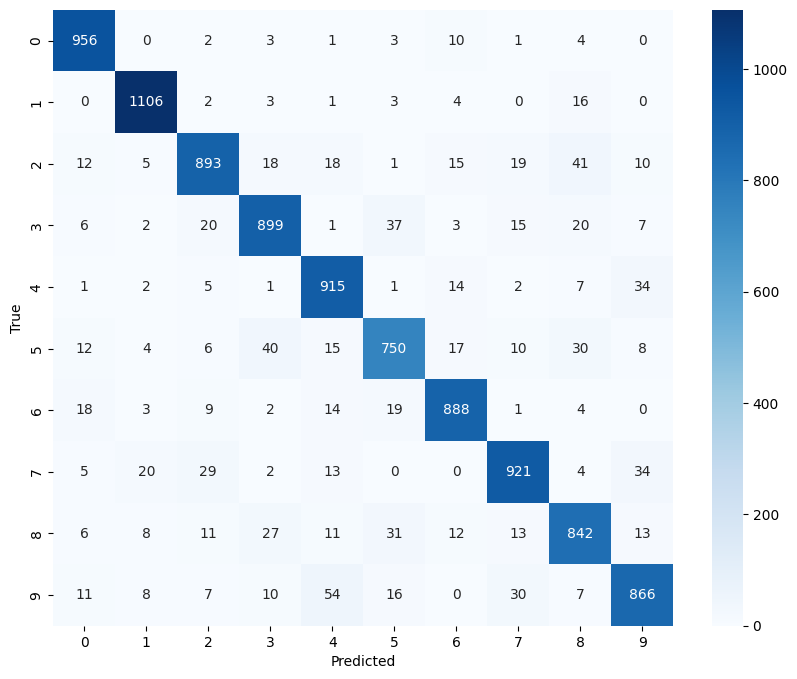

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_preds = np_predict(np_X_test)
y_true = np_y_test

conf_matrix = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## TODO

Add training (loss, acc) graphs.